In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from collections import Generator
from enum import Enum, auto
import pandas as pd
import seaborn as sns

## Simulation States

In [3]:
class HealthState(Enum):
    NORMAL = 1
    LOW_RISK_POLYP = 2
    HIGH_RISK_POLYP = 3
    ADENOMA = 4
    CRC_STAGE1 = 5
    CRC_STAGE2 = 6
    CRC_STAGE3 = 7
    CRC_STAGE4 = 8
    DEATH_OTHER_CAUSES = 9
    DEATH_CRC = 10
    DEATH_FROM_SCREENING = 11
    TREATED_CRCSTAGE1 = 12
    TREATED_CRCSTAGE2 = 13
    TREATED_CRCSTAGE3 = 14
    TREATED_CRCSTAGE4 = 15


class Sex(Enum):
    MALE = 1
    FEMALE = 2


class Procedure(Enum):
    GFOBT = 1
    FIT = 2
    FIT_FS = 3
    COLONOSCOPY = 4
    POLYPECTOMY = 5
    BIOPSY = 6
    ADENOMA_REMOVAL = 7
    CRC_TREATMENT1 = 8
    CRC_TREATMENT2 = 9
    CRC_TREATMENT3 = 10
    CRC_TREATMENT4 = 11


## Parameters

In [4]:
health_prevalence_rate = {
    HealthState.NORMAL: 0.699,
    HealthState.LOW_RISK_POLYP: 0.1216,
    HealthState.HIGH_RISK_POLYP: 0.0749,
    HealthState.ADENOMA: 0.079,
    HealthState.CRC_STAGE1: 0.015,
    HealthState.CRC_STAGE2: 0.0105
}


In [5]:
age_mortality_rate = {
    Sex.MALE: {
        54: 0.0076,
        59: 0.0089,
        64: 0.0102,
        69: 0.0106,
    },
    Sex.FEMALE: {
        54: 0.0054,
        59: 0.0065,
        64: 0.0077,
        69: 0.0089,
    }
}


In [6]:
health_state_transition_rate = {
    HealthState.NORMAL: {
        HealthState.ADENOMA: 0.013,
        HealthState.LOW_RISK_POLYP: 0.016,
        HealthState.NORMAL: 0.971
    },
    HealthState.LOW_RISK_POLYP: {
        HealthState.HIGH_RISK_POLYP: 0.02,
        HealthState.ADENOMA: 0.05,
        HealthState.LOW_RISK_POLYP: 0.93,
    },
    HealthState.HIGH_RISK_POLYP: {
        HealthState.CRC_STAGE1: 0.0326,
        HealthState.CRC_STAGE2: 0.0174,
        HealthState.HIGH_RISK_POLYP: 0.95,
    },
    HealthState.ADENOMA: {
        HealthState.CRC_STAGE1: 0.016,
        HealthState.CRC_STAGE2: 0.016,
        HealthState.ADENOMA: 0.968
    },
    HealthState.CRC_STAGE1: {
        HealthState.CRC_STAGE1: 0.7,
        HealthState.CRC_STAGE2: 0.3,
    },
    HealthState.CRC_STAGE2: {
        HealthState.DEATH_CRC: 0.01,
        HealthState.CRC_STAGE2: 0.69,
        HealthState.CRC_STAGE3: 0.3,
    },
    HealthState.CRC_STAGE3: {
        HealthState.DEATH_CRC: 0.06,
        HealthState.CRC_STAGE3: 0.375,
        HealthState.CRC_STAGE4: 0.565,
    },
    HealthState.CRC_STAGE4: {
        HealthState.DEATH_CRC: 0.387,
        HealthState.CRC_STAGE4: 0.613,
    },
    # Treated CRC Mortality Rate
    HealthState.TREATED_CRCSTAGE1: {
        HealthState.TREATED_CRCSTAGE1: 1,
    },
    HealthState.TREATED_CRCSTAGE2: {
        HealthState.DEATH_CRC: 0.005,
        HealthState.TREATED_CRCSTAGE2: 0.995,
    },
    HealthState.TREATED_CRCSTAGE3: {
        HealthState.DEATH_CRC: 0.03,
        HealthState.TREATED_CRCSTAGE3: 0.97,
    },
    HealthState.TREATED_CRCSTAGE4: {
        HealthState.DEATH_CRC: 0.193,
        HealthState.TREATED_CRCSTAGE4: 0.807
    },
}


In [7]:
symptomatic_crc_detection_rate = {
    HealthState.CRC_STAGE1: 0.2,
    HealthState.CRC_STAGE2: 0.2,
    HealthState.CRC_STAGE3: 0.65,
    HealthState.CRC_STAGE4: 1
}


In [8]:
treatment_survival_rate = {
    HealthState.CRC_STAGE1: 1,
    HealthState.CRC_STAGE2: 0.995,
    HealthState.CRC_STAGE3: 0.97,
    HealthState.CRC_STAGE4: 0.387,
}


In [9]:
utilities = {
    HealthState.NORMAL: 1,
    HealthState.LOW_RISK_POLYP: 0.871,
    HealthState.HIGH_RISK_POLYP: 0.827,
    HealthState.ADENOMA: 1,
    HealthState.CRC_STAGE1: 0.8295,
    HealthState.CRC_STAGE2: 0.859,
    HealthState.CRC_STAGE3: 0.8155,
    HealthState.CRC_STAGE4: 0.735,
    HealthState.TREATED_CRCSTAGE1: 0.8295,
    HealthState.TREATED_CRCSTAGE2: 0.859,
    HealthState.TREATED_CRCSTAGE3: 0.8155,
    HealthState.TREATED_CRCSTAGE4: 0.735,
    HealthState.DEATH_OTHER_CAUSES: 0,
    HealthState.DEATH_CRC: 0,
    HealthState.DEATH_FROM_SCREENING: 0
}

procedure_costs = {
    Procedure.GFOBT: 190.8731,
    Procedure.FIT: 404.5658,
    Procedure.FIT_FS: 4432.0871,
    Procedure.COLONOSCOPY: 5366.965,
    Procedure.POLYPECTOMY: 6311.9301,
    Procedure.BIOPSY: 3450,
    Procedure.ADENOMA_REMOVAL: 0,
    Procedure.CRC_TREATMENT1: 150000,
    Procedure.CRC_TREATMENT2: 283333.3333,
    Procedure.CRC_TREATMENT3: 350000,
    Procedure.CRC_TREATMENT4: 0,
}

In [10]:
colonoscopy_positive_detection_rate = {
    HealthState.NORMAL: 0,
    HealthState.LOW_RISK_POLYP: 0.5,
    HealthState.HIGH_RISK_POLYP: 0.5,
    HealthState.ADENOMA: 0.87,
    HealthState.CRC_STAGE1: 0.999,
    HealthState.CRC_STAGE2: 0.999,
    HealthState.CRC_STAGE3: 0.999,
    HealthState.CRC_STAGE4: 0.999
}

# Derived from Speci/Sensi/Prevalence using http://vassarstats.net/clin2.html
screening_modalities_positive_detection_rate = {
    Procedure.GFOBT: {
        HealthState.NORMAL: 0.8784,
        HealthState.LOW_RISK_POLYP: 0.9,
        HealthState.HIGH_RISK_POLYP: 0.9,
        HealthState.ADENOMA: 0.583,
        HealthState.CRC_STAGE1: 0.8305,
        HealthState.CRC_STAGE2: 0.8305,
        HealthState.CRC_STAGE3: 0.8305,
        HealthState.CRC_STAGE4: 0.8305
    },
    Procedure.FIT: {
        HealthState.NORMAL: 0.4608,
        HealthState.LOW_RISK_POLYP: 0.9,
        HealthState.HIGH_RISK_POLYP: 0.9,
        HealthState.ADENOMA: 0.795,
        HealthState.CRC_STAGE1: 0.9,
        HealthState.CRC_STAGE2: 0.9,
        HealthState.CRC_STAGE3: 0.9,
        HealthState.CRC_STAGE4: 0.9
    },
    Procedure.FIT_FS: {
        HealthState.NORMAL: 0.01,
        HealthState.LOW_RISK_POLYP: 0.99,
        HealthState.HIGH_RISK_POLYP: 0.99,
        HealthState.ADENOMA: 0.795,
        HealthState.CRC_STAGE1: 0.995,
        HealthState.CRC_STAGE2: 0.995,
        HealthState.CRC_STAGE3: 0.995,
        HealthState.CRC_STAGE4: 0.995
    }
}

colonoscopy_mortality_rate = 0.001296 * 0.1 + 0.003037 * 0.007453
adenoma_removal_success_rate = 0.6
qaly_discounting = 0.03
cost_discounting = 0.03

## Simulation Classes and Functions

In [11]:
class RandomCVGenerator(Generator):
    def __init__(self, seed=427):
        self.seed_genX = np.random.RandomState(seed)

    def send(self, stub):
        randomX = self.seed_genX.rand()
        return randomX

    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration


In [12]:
def dict_to_cumulative(d):
    res = {}
    for k, v in d.items():
        res[v] = k
    return res


In [13]:
to_treated = {
    HealthState.CRC_STAGE1: HealthState.TREATED_CRCSTAGE1,
    HealthState.CRC_STAGE2: HealthState.TREATED_CRCSTAGE2,
    HealthState.CRC_STAGE3: HealthState.TREATED_CRCSTAGE3,
    HealthState.CRC_STAGE4: HealthState.TREATED_CRCSTAGE4
}

to_treatment = {
    HealthState.CRC_STAGE1: Procedure.CRC_TREATMENT1,
    HealthState.CRC_STAGE2: Procedure.CRC_TREATMENT2,
    HealthState.CRC_STAGE3: Procedure.CRC_TREATMENT3,
    HealthState.CRC_STAGE4: Procedure.CRC_TREATMENT4
}


In [14]:
class Individual(object):
    def __init__(self, state_prob, sex_prob, init_states_prob={}):
        self.state = self.init_health_state(state_prob, init_states_prob)
        self.age = 50
        self.procedures = np.array([])
        self.previous_states = np.array([])
        self.sex = Sex.MALE if sex_prob < 0.5 else Sex.FEMALE
        self.qalys = 0
        self.costs = 0
        self.years_til_colonoscopy = 0
        self.get_FOBT = True
        
        if self.state is None:
            raise Exception('No State!')

    def init_health_state(self, state_prob, states):
        if states == {}:
            states = {
                HealthState.NORMAL: 0.699,
                HealthState.LOW_RISK_POLYP: 0.1216,
                HealthState.HIGH_RISK_POLYP: 0.0749,
                HealthState.ADENOMA: 0.079,
                HealthState.CRC_STAGE1: 0.02,
                HealthState.CRC_STAGE2: 0.0055
            }

        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(states)
        prev_k = 0
        sum_k = 0
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= state_prob < sum_k:
                return v
            prev_k += k

    @property
    def is_dead(self):
        if self.state == HealthState.DEATH_CRC or \
                self.state == HealthState.DEATH_FROM_SCREENING or \
                self.state == HealthState.DEATH_OTHER_CAUSES:
            return True
        else:
            return False

    @property
    def is_treated(self):
        if self.state == HealthState.TREATED_CRCSTAGE1 or \
                self.state == HealthState.TREATED_CRCSTAGE2 or \
                self.state == HealthState.TREATED_CRCSTAGE3 or \
                self.state == HealthState.TREATED_CRCSTAGE4:
            return True
        else:
            return False
        
    @property
    def has_cancer(self):
        if self.state == HealthState.CRC_STAGE1 or \
                self.state == HealthState.CRC_STAGE2 or \
                self.state == HealthState.CRC_STAGE3 or \
                self.state == HealthState.CRC_STAGE4:
            return True
        else:
            return False

    def __str__(self):
        return f'{self.age}: {self.state}'

    def __repr__(self):
        return self.__str__()


## Screening Strategies

In [15]:
def compute_other_mortality(individual):
    sex_mortality = age_mortality_rate[individual.sex]
    for k, v in sex_mortality.items():
        if individual.age > k:
            continue
        else:
            return v
    return


In [16]:
def no_screening(individual, num_gen):
    # Check dead
    if individual.is_dead:
        return None
    
    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    # Symptomatic Representation
    if symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        treatment_survival_prob = next(num_gen)
        if treatment_survival_prob <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, proc)
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    individual.age += 1

In [17]:
def colonoscopy_screening(individual, num_gen, compliance_rate_thresh):
    # Check dead
    if individual.is_dead:
        return None
    
    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    # Screening
    if next(num_gen) <= compliance_rate_thresh and \
            individual.years_til_colonoscopy == 0 and \
            not individual.is_treated:

        # Get colonoscopy
        individual.procedures = np.append(
            individual.procedures, Procedure.COLONOSCOPY)
        individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        # Probability of bleeding/perforation death
        if next(num_gen) <= colonoscopy_mortality_rate:
            individual.state = HealthState.DEATH_FROM_SCREENING

        else:
            if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                # Get Biopsy
                individual.procedures = np.append(
                    individual.procedures, Procedure.BIOPSY)
                individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                if individual.state == HealthState.LOW_RISK_POLYP or \
                        individual.state == HealthState.HIGH_RISK_POLYP:

                    # Get Polypectomy
                    individual.procedures = np.append(
                        individual.procedures, Procedure.POLYPECTOMY)
                    individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                    individual.state = HealthState.NORMAL

                elif individual.state == HealthState.ADENOMA:

                    # Get Adenoma Removal Surgery
                    individual.procedures = np.append(
                        individual.procedures, Procedure.ADENOMA_REMOVAL)
                    individual.costs += procedure_costs[Procedure.ADENOMA_REMOVAL] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                    if next(num_gen) <= adenoma_removal_success_rate:
                        individual.state = HealthState.NORMAL
                    else:
                        individual.state = HealthState.ADENOMA

                elif individual.has_cancer:

                    # Copy paste sadness
                    treatment_survival_prob = next(num_gen)
                    if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                        # Get the procedure for treatment
                        proc = to_treatment[individual.state]
                        individual.procedures = np.append(
                            individual.procedures, proc)
                        individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                        # Convert to treated
                        individual.state = to_treated[individual.state]
                    else:
                        # Copy paste sadness
                        ht_rate = health_state_transition_rate[individual.state]
                        # We just transpose the health states and probs
                        # to compare with the random number generated
                        states_conv = dict_to_cumulative(ht_rate)
                        prev_k = 0
                        sum_k = 0
                        htr_prob = next(num_gen)
                        for k, v in states_conv.items():
                            sum_k += k
                            if prev_k <= htr_prob < sum_k:
                                individual.state = v
                            prev_k += k
                else:
                    raise Exception(f'{i.state} - This should not happen')

                individual.years_til_colonoscopy = 1

            else:
                individual.years_til_colonoscopy = 10

    # Symptomatic Representation
    elif symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        if next(num_gen) <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, proc)
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    if individual.years_til_colonoscopy > 0:
        individual.years_til_colonoscopy -= 1
    individual.age += 1

In [18]:
def FOBT_screening(individual, num_gen, compliance_rate_thresh1, compliance_rate_thresh2, screening_modality):
    # Check dead
    if individual.is_dead:
        return None
    
    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    if next(num_gen) <= compliance_rate_thresh1 and individual.get_FOBT and not individual.is_treated:

        individual.procedures = np.append(
            individual.procedures, screening_modality)
        individual.costs += procedure_costs[screening_modality] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        fobt_detection_rate = screening_modalities_positive_detection_rate[
            screening_modality][individual.state]
        if next(num_gen) <= fobt_detection_rate:
            # Colonoscopy Screening
            if next(num_gen) <= compliance_rate_thresh2:
                # Get colonoscopy
                individual.procedures = np.append(
                    individual.procedures, Procedure.COLONOSCOPY)
                individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                # Probability of bleeding/perforation death
                if next(num_gen) <= colonoscopy_mortality_rate:
                    individual.state = HealthState.DEATH_FROM_SCREENING

                else:
                    if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                        # Get Biopsy
                        individual.procedures = np.append(
                            individual.procedures, Procedure.BIOPSY)
                        individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                        if individual.state == HealthState.LOW_RISK_POLYP or \
                                individual.state == HealthState.HIGH_RISK_POLYP:

                            # Get Polypectomy
                            individual.procedures = np.append(
                                individual.procedures, Procedure.POLYPECTOMY)
                            individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                            individual.state = HealthState.NORMAL
                            individual.get_FOBT = True

                        elif individual.state == HealthState.ADENOMA:

                            # Get Adenoma Removal Surgery
                            individual.procedures = np.append(
                                individual.procedures, Procedure.ADENOMA_REMOVAL)
                            individual.costs += procedure_costs[Procedure.ADENOMA_REMOVAL] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                            if next(num_gen) <= adenoma_removal_success_rate:
                                individual.state = HealthState.NORMAL
                                individual.get_FOBT = True
                            else:
                                individual.state = HealthState.ADENOMA

                        elif individual.has_cancer:

                            # Copy paste sadness
                            treatment_survival_prob = next(num_gen)
                            if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                                # Get the procedure for treatment
                                proc = to_treatment[individual.state]
                                individual.procedures = np.append(
                                    individual.procedures, proc)
                                individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                                # Convert to treated
                                individual.state = to_treated[individual.state]
                            else:
                                # Copy paste sadness
                                ht_rate = health_state_transition_rate[individual.state]
                                # We just transpose the health states and probs
                                # to compare with the random number generated
                                states_conv = dict_to_cumulative(ht_rate)
                                prev_k = 0
                                sum_k = 0
                                htr_prob = next(num_gen)
                                for k, v in states_conv.items():
                                    sum_k += k
                                    if prev_k <= htr_prob < sum_k:
                                        individual.state = v
                                    prev_k += k
                        else:
                            raise Exception(
                                f'{i.state} - This should not happen')

                        individual.years_til_colonoscopy = 1
                        individual.get_FOBT = False

                    else:
                        individual.years_til_colonoscopy = 10
                        individual.get_FOBT = False

    # Colonoscopy Screening
    elif next(num_gen) <= compliance_rate_thresh2 and \
            individual.years_til_colonoscopy == 0 and \
            not individual.is_treated and not individual.get_FOBT:

        # Get colonoscopy
        individual.procedures = np.append(
            individual.procedures, Procedure.COLONOSCOPY)
        individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        # Probability of bleeding/perforation death
        if next(num_gen) <= colonoscopy_mortality_rate:
            individual.state = HealthState.DEATH_FROM_SCREENING

        else:
            if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                # Get Biopsy
                individual.procedures = np.append(
                    individual.procedures, Procedure.BIOPSY)
                individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                if individual.state == HealthState.LOW_RISK_POLYP or \
                        individual.state == HealthState.HIGH_RISK_POLYP:

                    # Get Polypectomy
                    individual.procedures = np.append(
                        individual.procedures, Procedure.POLYPECTOMY)
                    individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                    individual.state = HealthState.NORMAL
                    individual.get_FOBT = True

                elif individual.state == HealthState.ADENOMA:

                    # Get Adenoma Removal Surgery
                    individual.procedures = np.append(
                        individual.procedures, Procedure.ADENOMA_REMOVAL)
                    individual.costs += procedure_costs[Procedure.ADENOMA_REMOVAL] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                    if next(num_gen) <= adenoma_removal_success_rate:
                        individual.state = HealthState.NORMAL
                        individual.get_FOBT = True
                    else:
                        individual.state = HealthState.ADENOMA

                elif individual.has_cancer:

                    # Copy paste sadness
                    treatment_survival_prob = next(num_gen)
                    if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                        # Get the procedure for treatment
                        proc = to_treatment[individual.state]
                        individual.procedures = np.append(
                            individual.procedures, proc)
                        individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                        # Convert to treated
                        individual.state = to_treated[individual.state]
                    else:
                        # Copy paste sadness
                        ht_rate = health_state_transition_rate[individual.state]
                        # We just transpose the health states and probs
                        # to compare with the random number generated
                        states_conv = dict_to_cumulative(ht_rate)
                        prev_k = 0
                        sum_k = 0
                        htr_prob = next(num_gen)
                        for k, v in states_conv.items():
                            sum_k += k
                            if prev_k <= htr_prob < sum_k:
                                individual.state = v
                            prev_k += k
                else:
                    raise Exception(f'{i.state} - This should not happen')

                individual.years_til_colonoscopy = 1

            else:
                individual.years_til_colonoscopy = 10

    # Symptomatic Representation
    elif symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        if next(num_gen) <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, proc)
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    if individual.years_til_colonoscopy > 0:
        individual.years_til_colonoscopy -= 1
    individual.age += 1

In [19]:
def to_df(individuals):
    df = pd.DataFrame()
    df['life_years'] = np.array(
        [len(i.previous_states) if not i.is_dead else len(i.previous_states) + 1 for i in individuals])
    df['cost'] = np.array([i.costs for i in individuals])
    df['qalys'] = np.array([i.qalys for i in individuals])
    return df


## Test Bed for No Screening

In [20]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen), 
                          init_states_prob=health_prevalence_rate)
               for _ in range(individual_count)]

(array([ 69882.,      0.,  12163.,      0.,   7613.,      0.,   7872.,
             0.,   1487.,    983.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

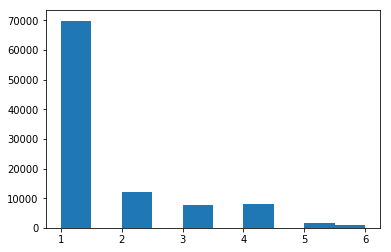

In [21]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [22]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        no_screening(i, sim_gen)

(array([  4.27310000e+04,   5.12900000e+03,   2.41170000e+04,
          8.03000000e+02,   2.90000000e+01,   4.80000000e+01,
          1.56090000e+04,   0.00000000e+00,   4.45400000e+03,
          7.08000000e+03]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

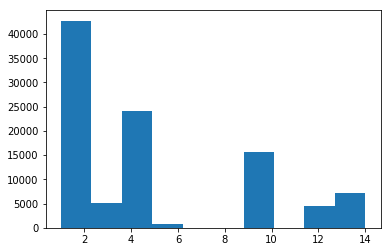

In [23]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [24]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 10])
prev_states.shape


(677,)

(array([  28.,   28.,  230.,    0.,    0.,    0.,    0.,    0.,  342.,   49.]),
 array([  6. ,   6.8,   7.6,   8.4,   9.2,  10. ,  10.8,  11.6,  12.4,
         13.2,  14. ]),
 <a list of 10 Patch objects>)

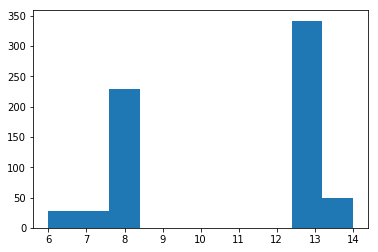

In [25]:
hist(prev_states)

In [26]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1718416.7199029124
Costs: 2967508090.361359
QALY Diff: 0.8592083599514562


(array([ 1131.,     0.,   391.,     0.,     0.,     0.,  4454.,     0.,
         6879.,   201.]),
 array([  9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ]),
 <a list of 10 Patch objects>)

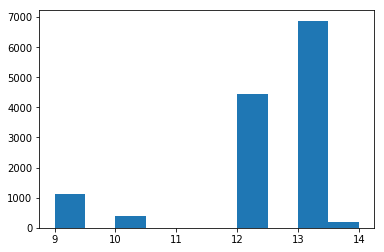

In [27]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 1]))


## Test Bed for Colonoscopy Screening

In [28]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)]

(array([ 69882.,      0.,  12163.,      0.,   7613.,      0.,   7872.,
             0.,   1487.,    983.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

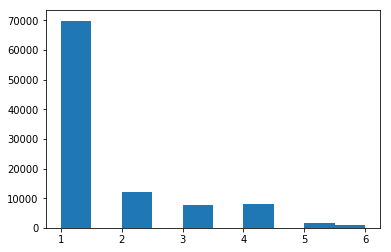

In [29]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [30]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        colonoscopy_screening(i, sim_gen, 1)

(array([  6.64730000e+04,   2.10200000e+03,   1.19390000e+04,
          2.53000000e+02,   2.00000000e+01,   1.33800000e+04,
          2.75000000e+02,   2.56800000e+03,   2.92100000e+03,
          6.90000000e+01]),
 array([  1. ,   2.4,   3.8,   5.2,   6.6,   8. ,   9.4,  10.8,  12.2,
         13.6,  15. ]),
 <a list of 10 Patch objects>)

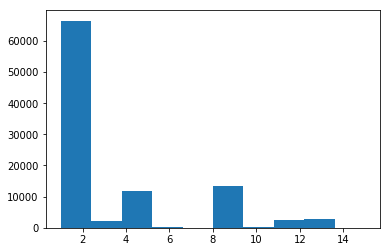

In [31]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [32]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 10])
prev_states.shape


(275,)

(array([  11.,    5.,   43.,    0.,    0.,    0.,    0.,  181.,   22.,   13.]),
 array([  6. ,   6.9,   7.8,   8.7,   9.6,  10.5,  11.4,  12.3,  13.2,
         14.1,  15. ]),
 <a list of 10 Patch objects>)

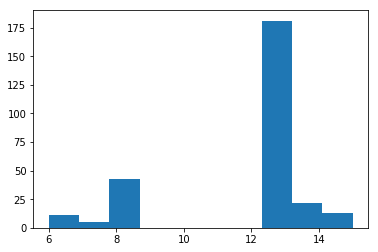

In [33]:
hist(prev_states)

In [34]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1774864.0024271845
Costs: 2872204211.417573
QALY Diff: 0.8874320012135922


(array([ 519.,    1.,   68.,    0.,    1.,    0.,   40.,    0.,    0.,    3.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ]),
 <a list of 10 Patch objects>)

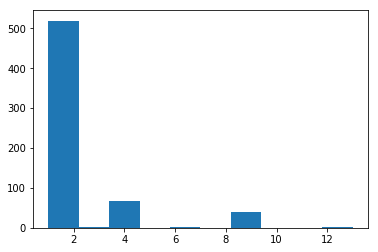

In [35]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 14]))


## Test Bed for G-FOBT Screening

In [77]:
individual_count = 10000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)]

(array([ 7016.,     0.,  1197.,     0.,   780.,     0.,   776.,     0.,
          143.,    88.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

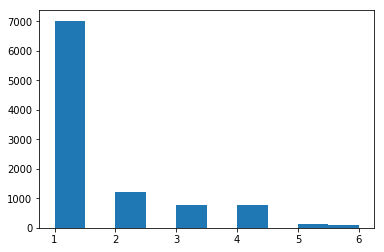

In [78]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [79]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        FOBT_screening(i, sim_gen, 0.1, 1, Procedure.GFOBT)

(array([  6.11800000e+03,   2.75000000e+02,   1.27700000e+03,
          2.90000000e+01,   2.00000000e+00,   2.00000000e+00,
          1.45900000e+03,   0.00000000e+00,   3.76000000e+02,
          4.62000000e+02]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

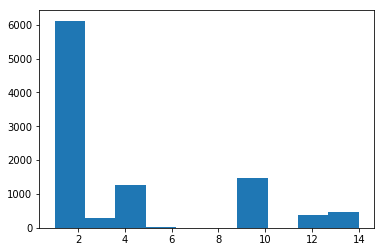

In [80]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [81]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 11])
prev_states.shape


(0,)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

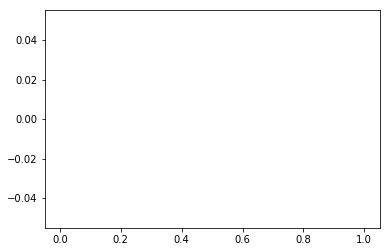

In [82]:
hist(prev_states)

In [83]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 174291.34029126214
Costs: 306843310.3800971
QALY Diff: 0.8714567014563107


(array([ 399.,    3.,   38.,    0.,    1.,    0.,   38.,    0.,    0.,    6.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ]),
 <a list of 10 Patch objects>)

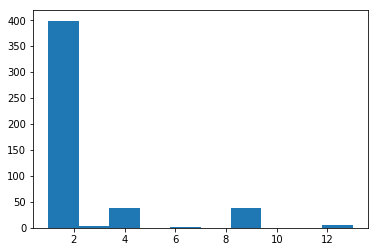

In [43]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 14]))


## Test Bed for FIT Screening

In [44]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)]

(array([ 69882.,      0.,  12163.,      0.,   7613.,      0.,   7872.,
             0.,   1487.,    983.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

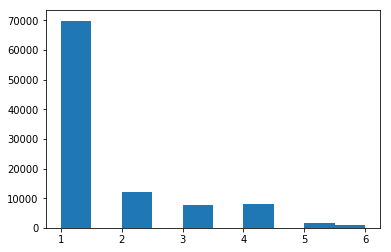

In [45]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [46]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        FOBT_screening(i, sim_gen, 1, 1, Procedure.FIT)

(array([  6.84440000e+04,   1.92700000e+03,   1.07830000e+04,
          2.30000000e+02,   1.60000000e+01,   1.29290000e+04,
          2.59000000e+02,   2.60900000e+03,   2.74900000e+03,
          5.40000000e+01]),
 array([  1. ,   2.4,   3.8,   5.2,   6.6,   8. ,   9.4,  10.8,  12.2,
         13.6,  15. ]),
 <a list of 10 Patch objects>)

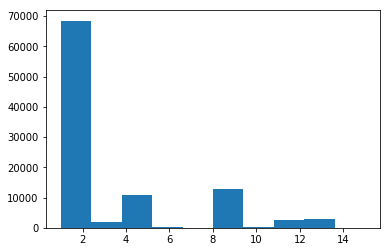

In [47]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [48]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 11])
prev_states.shape


(38,)

(array([ 29.,   0.,   4.,   0.,   0.,   2.,   0.,   2.,   0.,   1.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

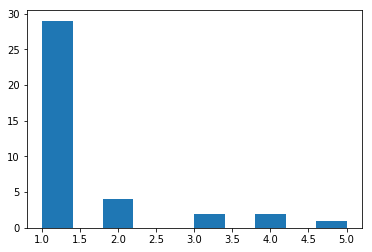

In [49]:
hist(prev_states)

In [50]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1783888.0155339807
Costs: 2902764678.125049
QALY Diff: 0.8919440077669903


(array([ 985.,    3.,   54.,    0.,    1.,    0.,   44.,    1.,    1.,    6.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ]),
 <a list of 10 Patch objects>)

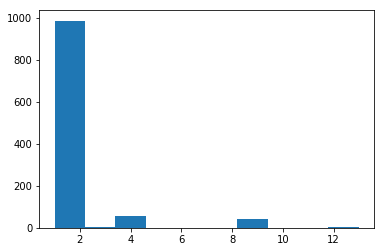

In [51]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 14]))


## Test Bed for FIT+FS Screening

In [52]:
individual_count = 100000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)]

(array([ 69882.,      0.,  12163.,      0.,   7613.,      0.,   7872.,
             0.,   1487.,    983.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

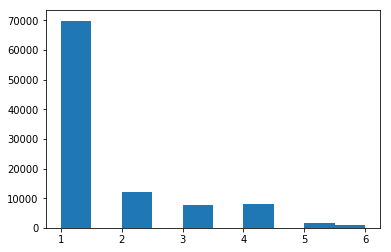

In [53]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [54]:
import multiprocessing as mp

# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        FOBT_screening(i, sim_gen, 1, 1, Procedure.FIT_FS)        
#     processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)]


(array([  8.66350000e+04,   1.16500000e+03,   3.23900000e+03,
          9.00000000e+01,   6.00000000e+00,   4.18700000e+03,
          1.73000000e+02,   2.44100000e+03,   2.03000000e+03,
          3.40000000e+01]),
 array([  1. ,   2.4,   3.8,   5.2,   6.6,   8. ,   9.4,  10.8,  12.2,
         13.6,  15. ]),
 <a list of 10 Patch objects>)

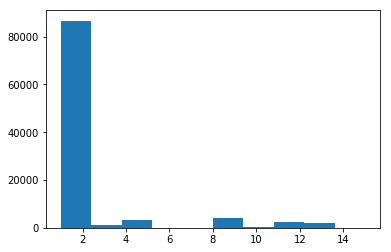

In [55]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [56]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 11])
prev_states.shape


(15,)

(array([ 9.,  0.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  2.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

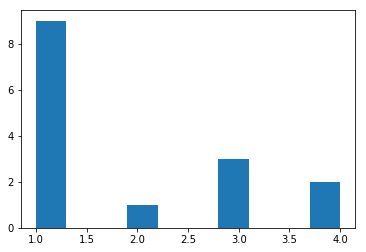

In [57]:
hist(prev_states)

In [58]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 1873007.15631068
Costs: 7802581936.587476
QALY Diff: 0.93650357815534


(array([  5.22300000e+03,   6.00000000e+00,   7.50000000e+01,
          1.00000000e+00,   0.00000000e+00,   3.70000000e+01,
          0.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          2.00000000e+00]),
 array([  1. ,   2.4,   3.8,   5.2,   6.6,   8. ,   9.4,  10.8,  12.2,
         13.6,  15. ]),
 <a list of 10 Patch objects>)

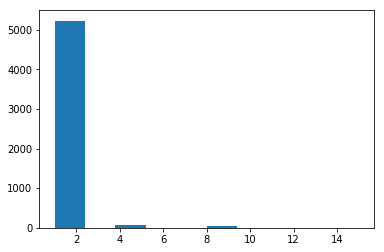

In [59]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 14]))


(array([   114.,    377.,    417.,    486.,    519.,    367.,    489.,
           518.,    527.,  96186.]),
 array([ 51. ,  52.9,  54.8,  56.7,  58.6,  60.5,  62.4,  64.3,  66.2,
         68.1,  70. ]),
 <a list of 10 Patch objects>)

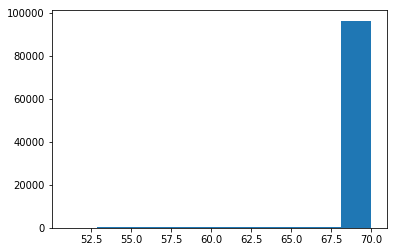

In [60]:
hist(
    np.array([i.age for i in individuals]))

In [61]:
7_802_581_936 / 100000

78025.81936

## Sensitivity Analysis for GFOBT Compliance Rates

In [20]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, compliance_rate/100, 1, Procedure.GFOBT)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys, 
                                           sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs, 
                                           sum(np.array([i.costs for i in individuals])))
    
    print(f'Sim {compliance_rate} - '\
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '\
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1723332.059223301 - Costs: 2997036972.6205826
Sim 2 - QALYs: 1726688.7300970873 - Costs: 3033199027.919223
Sim 3 - QALYs: 1730531.2737864077 - Costs: 3073242797.968641
Sim 4 - QALYs: 1734472.7999999998 - Costs: 3070536195.3594174
Sim 5 - QALYs: 1735254.6024271843 - Costs: 3086747286.794854
Sim 6 - QALYs: 1739067.3563106793 - Costs: 3078835725.896311
Sim 7 - QALYs: 1741028.9970873783 - Costs: 3096641154.167281
Sim 8 - QALYs: 1743203.5742718447 - Costs: 3102196660.7472816
Sim 9 - QALYs: 1745595.6985436892 - Costs: 3111792623.0447574
Sim 10 - QALYs: 1747609.8067961163 - Costs: 3078185324.683398
Sim 11 - QALYs: 1748863.8592233008 - Costs: 3097427525.2825236
Sim 12 - QALYs: 1751495.9703883494 - Costs: 3100252419.910097
Sim 13 - QALYs: 1751827.9733009709 - Costs: 3061851914.8818445
Sim 14 - QALYs: 1754310.445145631 - Costs: 3083629893.147281
Sim 15 - QALYs: 1755699.1033980583 - Costs: 3099748745.6784463
Sim 16 - QALYs: 1755254.4446601938 - Costs: 3067414748.4962134
Sim 17 - QA

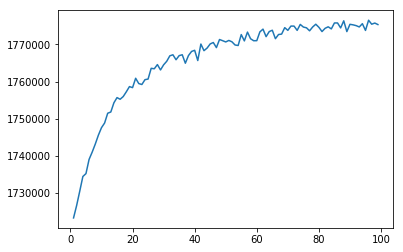

In [25]:
plot(range(1,100), individual_sensitivity_qalys)

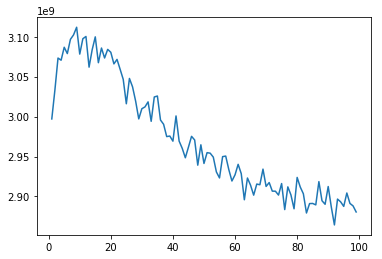

In [26]:
plot(range(1,100), individual_sensitivity_costs)

In [27]:
from statsmodels.tsa.filters.hp_filter import hpfilter

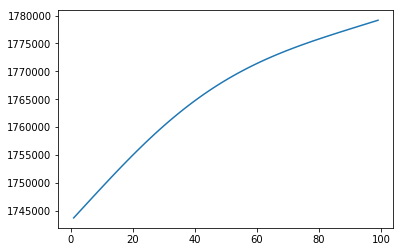

In [29]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*52**2 )[1])

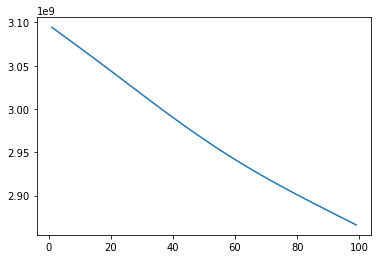

In [30]:
plot(range(1, 100), hpfilter(individual_sensitivity_costs, lamb=100*52**2)[1])

## Sensitivity Analysis for FIT Compliance Rates

In [31]:
individual_sensitivity_qalys = np.array([])
individual_sensitivity_costs = np.array([])

# Simulate!
for compliance_rate in range(1, 100):
    individual_count = 100000
    rand_individual_state_gen = RandomCVGenerator()
    rand_individual_sex_gen = RandomCVGenerator(724)

    individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                              init_states_prob=health_prevalence_rate) for _ in range(individual_count)]
    sim_gen = RandomCVGenerator()
    for k in range(20):
        for i in individuals:
            FOBT_screening(i, sim_gen, compliance_rate/100, 1, Procedure.FIT)
    individual_sensitivity_qalys = np.append(individual_sensitivity_qalys, 
                                           sum(np.array([i.qalys for i in individuals])))
    individual_sensitivity_costs = np.append(individual_sensitivity_costs, 
                                           sum(np.array([i.costs for i in individuals])))
    
    print(f'Sim {compliance_rate} - '\
          f'QALYs: {sum(np.array([i.qalys for i in individuals]))} - '\
          f'Costs: {sum(np.array([i.costs for i in individuals]))}')

Sim 1 - QALYs: 1723137.2558252427 - Costs: 2960404600.64
Sim 2 - QALYs: 1728025.3538834949 - Costs: 3031064839.4803886
Sim 3 - QALYs: 1730602.6116504853 - Costs: 2996428471.3912625
Sim 4 - QALYs: 1735190.3752427183 - Costs: 2990292258.4176702
Sim 5 - QALYs: 1735381.6650485434 - Costs: 2946625165.553495
Sim 6 - QALYs: 1738544.5291262139 - Costs: 2955898210.8224277
Sim 7 - QALYs: 1741898.653883495 - Costs: 2967621071.940291
Sim 8 - QALYs: 1742921.6742718446 - Costs: 2951247395.2441745
Sim 9 - QALYs: 1745272.6247572817 - Costs: 2968015728.4166017
Sim 10 - QALYs: 1749593.4543689315 - Costs: 2966599914.9007773
Sim 11 - QALYs: 1750039.0558252428 - Costs: 2946556551.5566998
Sim 12 - QALYs: 1754436.4150485434 - Costs: 2958776424.328156
Sim 13 - QALYs: 1754044.077184466 - Costs: 2979407527.578544
Sim 14 - QALYs: 1754894.7582524277 - Costs: 2952559417.075631
Sim 15 - QALYs: 1755470.9480582525 - Costs: 2950495831.4396114
Sim 16 - QALYs: 1757216.5271844657 - Costs: 2955993069.3513584
Sim 17 - QALY

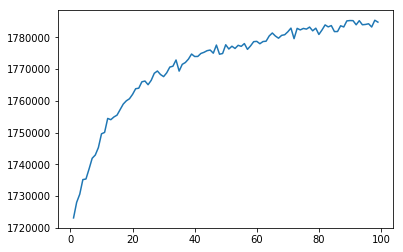

In [32]:
plot(range(1,100), individual_sensitivity_qalys)

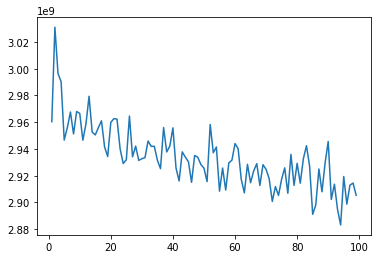

In [33]:
plot(range(1,100), individual_sensitivity_costs)

In [34]:
from statsmodels.tsa.filters.hp_filter import hpfilter

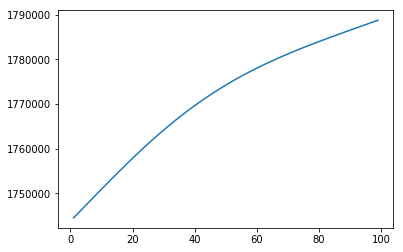

In [35]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*52**2 )[1])

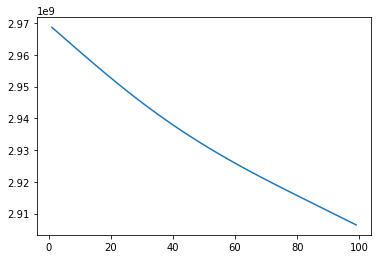

In [36]:
plot(range(1, 100), hpfilter(individual_sensitivity_costs, lamb=100*52**2)[1])

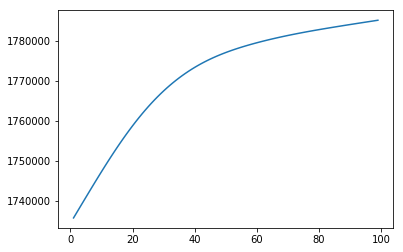

In [49]:
plot(range(1, 100), hpfilter(individual_sensitivity_qalys, lamb=100*15**2)[1])